# Load Libraries and Data

In [54]:
#!pip install xgboost
#!pip install lightgbm
#!pip install catboost

In [55]:
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,
    cohen_kappa_score, make_scorer
)
import matplotlib.pyplot as plt
import joblib
from sklearn.utils.class_weight import compute_class_weight
from sklearn.impute import SimpleImputer

# Importing Gradient Boosting Models
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier #type: ignore
from sklearn.ensemble import VotingClassifier

import warnings  # Import warnings module

# Suppress all warnings
warnings.filterwarnings('ignore')

def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)

set_seed(42)

In [56]:
# Paths to data files
train_csv_path = './data/merged_train.csv'
test_csv_path = './data/merged_test.csv'

# Load the CSV files
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

# Data Preprocessing

In [57]:
# Ensure 'sii' is not in the features
X = train_df.drop(columns=['id', 'sii'])
y = train_df['sii'].astype(np.int64)

X_test = test_df.drop(columns=['id'])

In [ ]:
# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# Update numerical pipeline with imputer
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Update categorical pipeline with imputer
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))#,
    #('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing pipelines
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

In [59]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Fitting Boosting Models

In [60]:
# Compute class weights to handle class imbalance
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_dict = dict(zip(classes, class_weights))

# Define a custom scoring function using Quadratic Weighted Kappa
def qwk_scorer(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

kappa_scorer = make_scorer(qwk_scorer)

In [61]:
# Use Stratified K-Folds Cross-Validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


Best Cross-Validation QWK Score (LightGBM): 0.9997
Best Parameters (LightGBM): {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 100, 'classifier__num_leaves': 31, 'classifier__subsample': 0.8}

Validation Accuracy (LightGBM): 1.0000

Classification Report (LightGBM):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       563
           1       1.00      1.00      1.00       146
           2       1.00      1.00      1.00        76
           3       1.00      1.00      1.00         7

    accuracy                           1.00       792
   macro avg       1.00      1.00      1.00       792
weighted avg       1.00      1.00      1.00       792



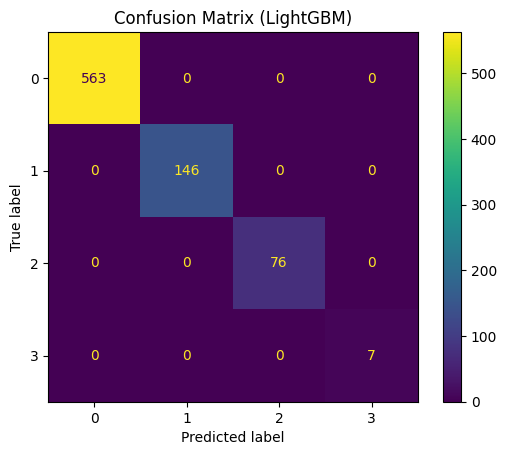


Best LightGBM model has been saved successfully.


In [62]:
# Create a Pipeline that includes preprocessing and the LightGBM classifier
lgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(class_weight=class_weights_dict, random_state=42, verbose=-1))
])

# Define parameter grid for LightGBM
lgb_params = {
    'classifier__n_estimators': [50, 100],
    'classifier__learning_rate': [0.1],
    'classifier__max_depth': [3, 5],
    'classifier__num_leaves': [31],
    'classifier__subsample': [0.8],
    'classifier__colsample_bytree': [0.8],
}

# GridSearchCV for LightGBM
lgb_gs = GridSearchCV(
    estimator=lgb_pipeline,
    param_grid=lgb_params,
    cv=skf,
    scoring=kappa_scorer,
    refit=True,
    verbose=0,
    n_jobs=-1
)

# Fit the model on the training data
lgb_gs.fit(X_train, y_train)

# Print best cross-validation score and parameters
print(f"\nBest Cross-Validation QWK Score (LightGBM): {lgb_gs.best_score_:.4f}")
print(f"Best Parameters (LightGBM): {lgb_gs.best_params_}")

# Retrieve the best model pipeline
lgb_best_pipeline = lgb_gs.best_estimator_

# Predict on the validation set
y_val_pred = lgb_best_pipeline.predict(X_val)

# Calculate accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Accuracy (LightGBM): {val_accuracy:.4f}")

# Classification Report
print("\nClassification Report (LightGBM):")
print(classification_report(y_val, y_val_pred))

# Confusion Matrix
conf_mat = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.title("Confusion Matrix (LightGBM)")
plt.show()

# Save the best model pipeline
joblib.dump(lgb_best_pipeline, 'best_lgb_model.pkl')
print("\nBest LightGBM model has been saved successfully.")


Best Cross-Validation QWK Score (XGBoost): 1.0000
Best Parameters (XGBoost): {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 50, 'classifier__subsample': 0.8}

Validation Accuracy (XGBoost): 1.0000

Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       563
           1       1.00      1.00      1.00       146
           2       1.00      1.00      1.00        76
           3       1.00      1.00      1.00         7

    accuracy                           1.00       792
   macro avg       1.00      1.00      1.00       792
weighted avg       1.00      1.00      1.00       792



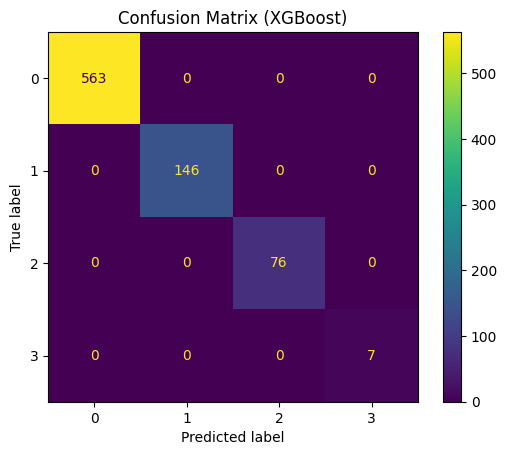


Best XGBoost model has been saved successfully.


In [63]:
# Create a Pipeline that includes preprocessing and the XGBoost classifier
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42, eval_metric='mlogloss', use_label_encoder=False, verbosity=0))
])

# Define parameter grid for XGBoost
xgb_params = {
    'classifier__n_estimators': [50, 100],
    'classifier__learning_rate': [0.1],
    'classifier__max_depth': [3, 5],
    'classifier__subsample': [0.8],
    'classifier__colsample_bytree': [0.8],
    # Removed 'scale_pos_weight'
}

# GridSearchCV for XGBoost
xgb_gs = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=xgb_params,
    cv=skf,
    scoring=kappa_scorer,
    refit=True,
    verbose=0,
    n_jobs=-1
)

# Fit the model on the training data
xgb_gs.fit(X_train, y_train)

# Print best cross-validation score and parameters
print(f"\nBest Cross-Validation QWK Score (XGBoost): {xgb_gs.best_score_:.4f}")
print(f"Best Parameters (XGBoost): {xgb_gs.best_params_}")

# Retrieve the best model pipeline
xgb_best_pipeline = xgb_gs.best_estimator_

# Predict on the validation set
y_val_pred = xgb_best_pipeline.predict(X_val)

# Calculate accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Accuracy (XGBoost): {val_accuracy:.4f}")

# Classification Report
print("\nClassification Report (XGBoost):")
print(classification_report(y_val, y_val_pred))

# Confusion Matrix
conf_mat = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.title("Confusion Matrix (XGBoost)")
plt.show()

# Save the best model pipeline
joblib.dump(xgb_best_pipeline, 'best_xgb_model.pkl')
print("\nBest XGBoost model has been saved successfully.")


Best Cross-Validation QWK Score (CatBoost): 0.9987
Best Parameters (CatBoost): {'classifier__border_count': 64, 'classifier__depth': 3, 'classifier__iterations': 500, 'classifier__l2_leaf_reg': 3, 'classifier__learning_rate': 0.1}

Validation Accuracy (CatBoost): 0.9987

Classification Report (CatBoost):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       563
           1       1.00      1.00      1.00       146
           2       1.00      0.99      0.99        76
           3       0.88      1.00      0.93         7

    accuracy                           1.00       792
   macro avg       0.97      1.00      0.98       792
weighted avg       1.00      1.00      1.00       792



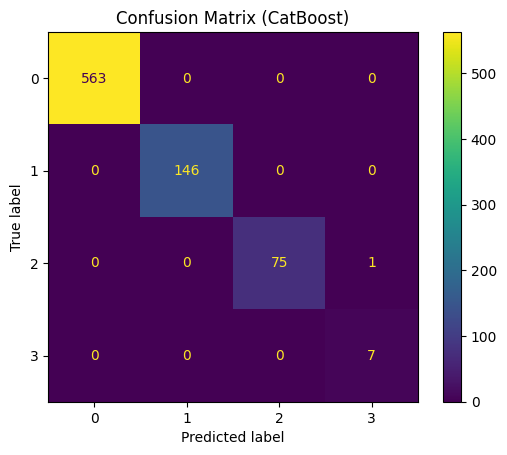


Best CatBoost model has been saved successfully.


In [65]:
# Create a Pipeline that includes preprocessing and the CatBoost classifier
cat_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', CatBoostClassifier(class_weights=class_weights.tolist(), random_state=42, verbose=0))
])

# Define parameter grid for CatBoost
cat_params = {
    'classifier__iterations': [500],
    'classifier__learning_rate': [0.1],
    'classifier__depth': [3, 5],
    'classifier__l2_leaf_reg': [3, 5],
    'classifier__border_count': [32, 64],
}

# GridSearchCV for CatBoost
cat_gs = GridSearchCV(
    estimator=cat_pipeline,
    param_grid=cat_params,
    cv=skf,
    scoring=kappa_scorer,
    refit=True,
    verbose=0,
    n_jobs=-1
)

# Fit the model on the training data
cat_gs.fit(X_train, y_train)

# Print best cross-validation score and parameters
print(f"\nBest Cross-Validation QWK Score (CatBoost): {cat_gs.best_score_:.4f}")
print(f"Best Parameters (CatBoost): {cat_gs.best_params_}")

# Retrieve the best model pipeline
cat_best_pipeline = cat_gs.best_estimator_

# Predict on the validation set
y_val_pred = cat_best_pipeline.predict(X_val)

# Calculate accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Accuracy (CatBoost): {val_accuracy:.4f}")

# Classification Report
print("\nClassification Report (CatBoost):")
print(classification_report(y_val, y_val_pred))

# Confusion Matrix
conf_mat = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.title("Confusion Matrix (CatBoost)")
plt.show()

# Save the best model pipeline
joblib.dump(cat_best_pipeline, 'best_cat_model.pkl')
print("\nBest CatBoost model has been saved successfully.")

# Fitting a VotingClassifier


Validation Accuracy (Ensemble): 1.0000

Classification Report (Ensemble):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       563
           1       1.00      1.00      1.00       146
           2       1.00      1.00      1.00        76
           3       1.00      1.00      1.00         7

    accuracy                           1.00       792
   macro avg       1.00      1.00      1.00       792
weighted avg       1.00      1.00      1.00       792



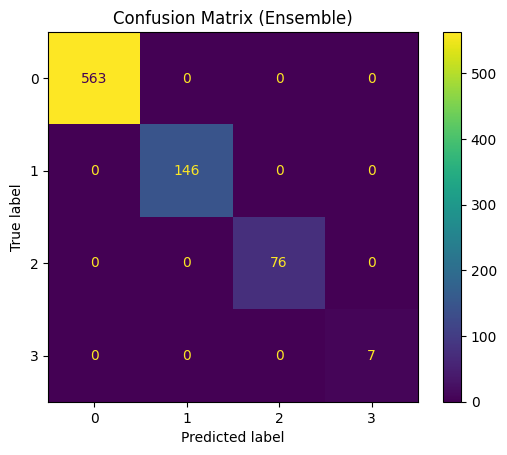


Best Ensemble model has been saved successfully.


In [66]:
# Fit the best models on the combined training and validation set
X_full = pd.concat([X_train, X_val], axis=0)
y_full = pd.concat([y_train, y_val], axis=0)

# Refit the best models on the full dataset
lgb_best_pipeline.fit(X_full, y_full)
xgb_best_pipeline.fit(X_full, y_full)
cat_best_pipeline.fit(X_full, y_full)

# Extract the classifiers from the pipelines
lgb_clf = lgb_best_pipeline.named_steps['classifier']
xgb_clf = xgb_best_pipeline.named_steps['classifier']
cat_clf = cat_best_pipeline.named_steps['classifier']

# Create a VotingClassifier ensemble
ensemble_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', VotingClassifier(
        estimators=[
            ('lgb', lgb_clf),
            ('xgb', xgb_clf),
            ('cat', cat_clf)
        ],
        voting='soft',  # Use 'soft' voting to consider predicted probabilities
        weights=[1, 1, 1],
        n_jobs=-1
    ))
])

# Fit the ensemble model on the full dataset
ensemble_pipeline.fit(X_full, y_full)

# Predict on the validation set
y_val_pred = ensemble_pipeline.predict(X_val)

# Calculate accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Accuracy (Ensemble): {val_accuracy:.4f}")

# Classification Report
print("\nClassification Report (Ensemble):")
print(classification_report(y_val, y_val_pred))

# Confusion Matrix
conf_mat = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.title("Confusion Matrix (Ensemble)")
plt.show()

# Save the ensemble model
joblib.dump(ensemble_pipeline, 'best_ensemble_model.pkl')
print("\nBest Ensemble model has been saved successfully.")

In [ ]:
# Ensure that the test data is preprocessed properly
X_test_preprocessed = preprocessor.transform(X_test)

# Predict using the ensemble model
y_test_pred = ensemble_pipeline.named_steps['classifier'].predict(X_test_preprocessed)

# Prepare submission
submission = pd.DataFrame({
    'id': test_df['id'],
    'sii': y_test_pred
})

# Save submission
#submission.to_csv('ensemble_submission.csv', index=False)
print("\nSubmission saved as 'ensemble_submission.csv'")


Submission saved as 'ensemble_submission.csv'
